In [39]:
from math import ceil
from omegaconf import OmegaConf
from sampler import BaseSampler
from utils import util_common
from utils import util_image
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torchvision as thv
import tifffile
from skimage.metrics import structural_similarity

In [40]:
def metrics_ssim(img1, img2):
    data_range = max(np.max(img1), np.max(img2)) - min(np.min(img1), np.min(img2))
    # data_range = np.max(img1) - np.min(img1)
    # data_range = np.max(img2) - np.min(img2)
    (score, diff) = structural_similarity(img1, img2, full=True, data_range=data_range)
    return score

In [2]:
class DiffusionSampler(BaseSampler):
    def sample_func(self, noise=None, start_timesteps=None, bs=4, num_images=1000, save_dir=None):
        print('Begining sampling:')

        h = w = self.configs.im_size
        if self.num_gpus != 0:
            total_iters = ceil(num_images / (bs * self.num_gpus))
        else:
            total_iters = ceil(num_images / (bs * 1))
        for ii in range(total_iters):
            if self.rank == 0 and self.display:
                print(f'Processing: {ii+1}/{total_iters}')
            if noise == None:
                if self.num_gpus != 0:
                    noise = torch.randn((bs, 1, h, w), dtype=torch.float32).cuda()
                else:
                    noise = torch.randn((bs, 1, h, w), dtype=torch.float32)
            if 'ddim' in self.configs.diffusion.params.timestep_respacing:
                sample = self.diffusion.ddim_sample_loop(
                        self.model,
                        shape=(bs, 1, h, w),
                        noise=noise,
                        start_timesteps=start_timesteps,
                        clip_denoised=True,
                        denoised_fn=None,
                        model_kwargs=None,
                        device=None,
                        progress=False,
                        eta=0.0,
                        )
            else:
                sample = self.diffusion.p_sample_loop(
                        self.model,
                        shape=(bs, 1, h, w),
                        noise=noise,
                        start_timesteps=start_timesteps,
                        clip_denoised=True,
                        denoised_fn=None,
                        model_kwargs=None,
                        device=None,
                        progress=False,
                        )
            sample = util_image.normalize_th(sample, reverse=True).clamp(0.0, 1.0)
        return sample

In [3]:
planaria_data = np.load('/Users/schaudhary/siva_projects/Denoising_Planaria/train_data/data_label.npz')
planaria_data_Y = planaria_data['Y']
planaria_data_X = planaria_data['X']

In [11]:
def plot_image_row(images, names=None):
    fig, ax = plt.subplots(1, len(images), figsize=(5*len(images), 5))
    for i in range(len(images)):
        ax[i].imshow(images[i][0, 0])
        ax[i].axis('off')
        if names != None:
            ax[i].set_title(names[i])

def plot_denoise_example(y0, xN_given_y0, x0_sampled, x0):
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    ax[0].imshow(y0[0, 0])
    ax[1].imshow(xN_given_y0[0, 0])
    ax[2].imshow(x0_sampled[0, 0])
    ax[3].imshow(x0[0, 0])
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    ax[3].axis('off')
    ax[0].set_title('noisy')
    ax[1].set_title('noisy_forward')
    ax[2].set_title('denoised')
    ax[3].set_title('gt')

In [4]:
transform = thv.transforms.Normalize(mean=(0.5), std=(0.5))

# simple denoising

In [5]:
cfg_path = '/Users/schaudhary/siva_projects/DifFace/configs/sample/iddpm_care_planaria_2D.yaml'
gpu_id = ''
timestep_respacing = '1000'
bs = 1
num_images = 1
save_dir = ''

configs = OmegaConf.load(cfg_path)
configs.gpu_id = gpu_id
configs.diffusion.params.timestep_respacing = timestep_respacing

sampler_dist = DiffusionSampler(configs)

In [165]:
tN = torch.tensor(100)
y0 = transform(torch.tensor(planaria_data_X[2000:2001, 0, 14:15], dtype=torch.float32))
x0 = torch.tensor(planaria_data_Y[2000:2001, 0, 14:15], dtype=torch.float32)
all_samples = []
for n in range(10):
    xN_given_y0 = sampler_dist.diffusion.q_sample(y0, tN)
    x0_sampled = sampler_dist.sample_func(noise=xN_given_y0, start_timesteps=tN, bs=bs, num_images=num_images, save_dir=save_dir)
    all_samples.append(x0_sampled)
x0_sampled = torch.mean(torch.cat(all_samples, dim=0), dim=0, keepdim=True)

Begining sampling:
Begining sampling:
Begining sampling:
Begining sampling:
Begining sampling:
Begining sampling:
Begining sampling:
Begining sampling:
Begining sampling:
Begining sampling:


In [166]:
metrics_ssim(x0[0, 0].numpy(), 0.5*y0[0, 0].numpy()+0.5), metrics_ssim(x0[0, 0].numpy(), x0_sampled[0, 0].numpy())

(0.31347506460523306, 0.6679123188817473)

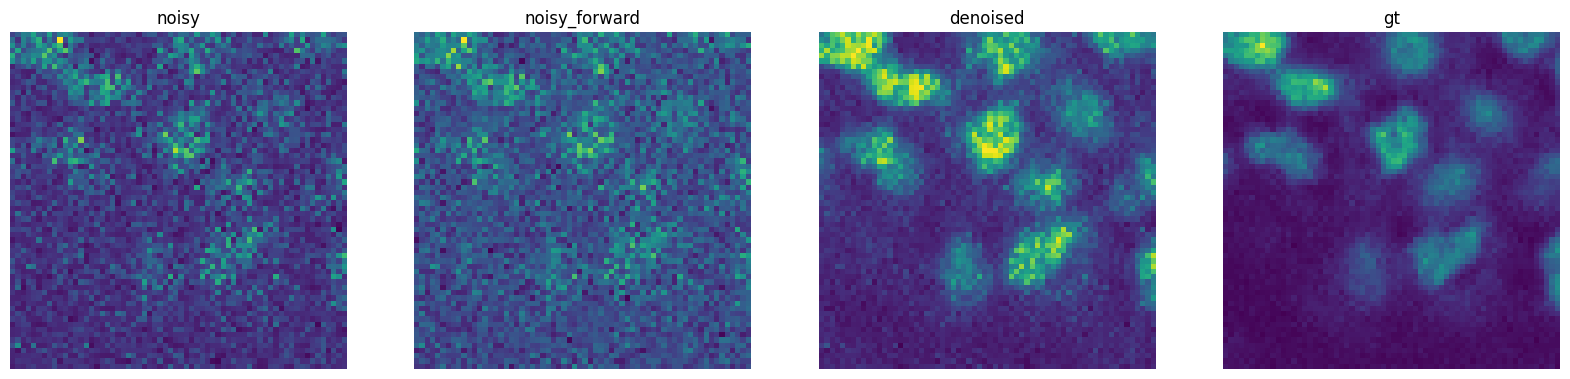

In [167]:
plot_denoise_example(y0, xN_given_y0, x0_sampled, x0)

In [129]:
n2v_pred = tifffile.imread('/Users/schaudhary/siva_projects/DifFace/baseline_denoising/N2V/N2V_planaria/predictions/train_idx2000_z14.tif')
tN = torch.tensor(100)
y0 = torch.permute(torch.tensor(n2v_pred, dtype=torch.float32), [2, 0, 1])
y0 = y0[None, :, :, :]
y0 = transform(y0)
x0 = torch.tensor(planaria_data_Y[2000:2001, 0, 14:15], dtype=torch.float32)
for n in range(10):
    xN_given_y0 = sampler_dist.diffusion.q_sample(y0, tN)
    x0_sampled = sampler_dist.sample_func(noise=xN_given_y0, start_timesteps=tN, bs=bs, num_images=num_images, save_dir=save_dir)
    all_samples.append(x0_sampled)
x0_sampled = torch.mean(torch.cat(all_samples, dim=0), dim=0, keepdim=True)

Begining sampling:
Begining sampling:
Begining sampling:
Begining sampling:
Begining sampling:
Begining sampling:
Begining sampling:
Begining sampling:
Begining sampling:
Begining sampling:


In [131]:
metrics_ssim(x0[0, 0].numpy(), 0.5*y0[0, 0].numpy()+0.5), metrics_ssim(x0[0, 0].numpy(), x0_sampled[0, 0].numpy())

(0.6233747883275701, 0.6874494393058254)

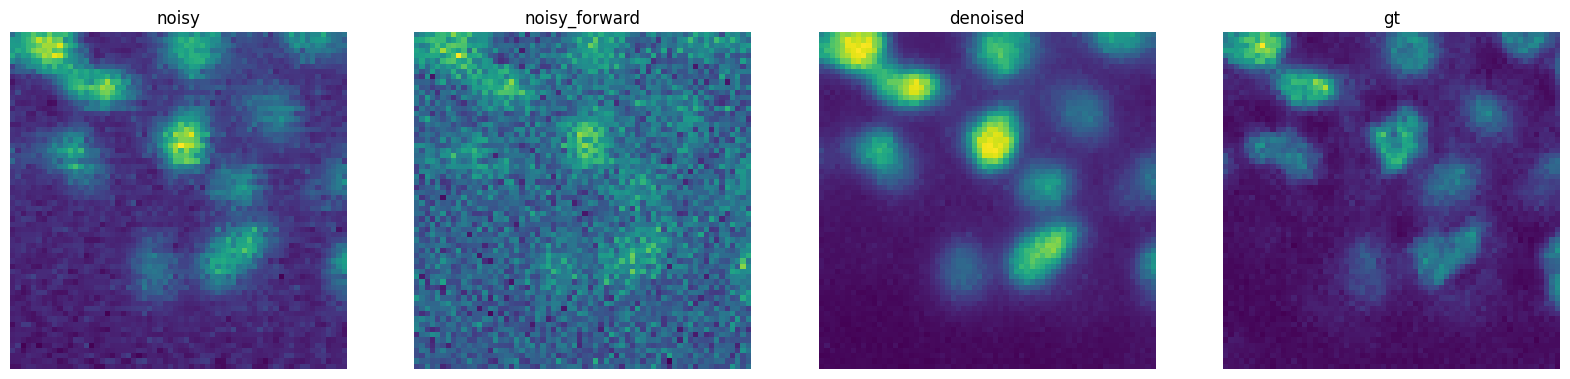

In [132]:
plot_denoise_example(y0, xN_given_y0, x0_sampled, x0)

In [111]:
care_pred = tifffile.imread('/Users/schaudhary/siva_projects/DifFace/baseline_denoising/care/care_planaria_2D/predictions/train_idx2000_z14.tif')
tN = torch.tensor(100)
y0 = torch.permute(torch.tensor(care_pred, dtype=torch.float32), [2, 0, 1])
y0 = y0[None, :, :, :]
y0 = transform(y0)
x0 = torch.tensor(planaria_data_Y[2000:2001, 0, 14:15], dtype=torch.float32)
for n in range(10):
    xN_given_y0 = sampler_dist.diffusion.q_sample(y0, tN)
    x0_sampled = sampler_dist.sample_func(noise=xN_given_y0, start_timesteps=tN, bs=bs, num_images=num_images, save_dir=save_dir)
    all_samples.append(x0_sampled)
x0_sampled = torch.mean(torch.cat(all_samples, dim=0), dim=0, keepdim=True)

Begining sampling:
Begining sampling:
Begining sampling:
Begining sampling:
Begining sampling:
Begining sampling:
Begining sampling:
Begining sampling:
Begining sampling:
Begining sampling:


In [113]:
metrics_ssim(x0[0, 0].numpy(), 0.5*y0[0, 0].numpy()+0.5)

0.660169191273122

In [116]:
metrics_ssim(x0[0, 0].numpy(), x0_sampled[0, 0].numpy())

0.6932335089134688

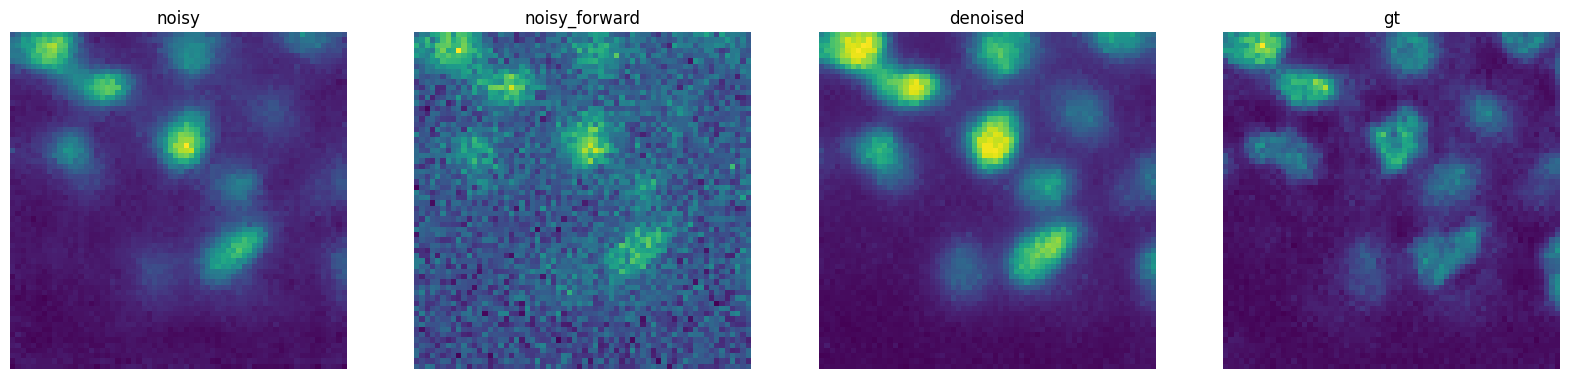

In [118]:
plot_denoise_example(y0, xN_given_y0, x0_sampled, x0)

# denoise by mixing

In [65]:
cfg_path = '/Users/schaudhary/siva_projects/DifFace/configs/sample/iddpm_care_planaria_2D.yaml'
gpu_id = ''
timestep_respacing = '1000'
bs = 1
num_images = 1
save_dir = ''

configs = OmegaConf.load(cfg_path)
configs.gpu_id = gpu_id
configs.diffusion.params.timestep_respacing = timestep_respacing

sampler_dist = DiffusionSampler(configs)

In [168]:
def linear_mixing_alphas(min_alpha, max_alpha, n_steps):
    mixing_alphas = np.linspace(min_alpha, max_alpha, n_steps - 1)
    return mixing_alphas

def constant_mixing_alphas(alpha, n_steps):
    mixing_alphas = [alpha for i in range(n_steps - 1)]
    return mixing_alphas


y0 = transform(torch.tensor(planaria_data_X[2000:2001, 0, 14:15], dtype=torch.float32))

# n2v_pred = tifffile.imread('/Users/schaudhary/siva_projects/DifFace/baseline_denoising/N2V/N2V_planaria/predictions/train_idx2000_z14.tif')
# y0 = torch.permute(torch.tenscccccbcucjlvkifrcnvrjvutbbkgnuverjkibcledhfk
or(n2v_pred, dtype=torch.float32), [2, 0, 1])
# y0 = y0[None, :, :, :]
# y0 = transform(y0)

tN = torch.tensor(1000)
x0 = torch.tensor(planaria_data_Y[2000:2001, 0, 14:15], dtype=torch.float32)
n_steps = 900
mix_start = tN
mix_stop = 100
assert (mix_start - mix_stop) % n_steps == 0
mixing_t_steps = {mix_stop + i*int((mix_start - mix_stop)/n_steps):i for i in range(1, n_steps)}
mixing_alphas = constant_mixing_alphas(0.1, n_steps)
# mixing_alphas = linear_mixing_alphas(0.01, 0.99, n_steps)
mixing_xN_given_y0 = [sampler_dist.diffusion.q_sample(y0, torch.tensor(step)) for step in mixing_t_steps]
xN_given_y0 = sampler_dist.diffusion.q_sample(y0, tN - 1)
img = xN_given_y0

h = w = configs.im_size
shape = (bs, 1, h, w)
indices = list(range(tN)[::-1])
for i in indices:
    t = torch.tensor([i] * shape[0], device=y0.device)
    with torch.no_grad():
        out = sampler_dist.diffusion.p_sample(
            sampler_dist.model,
            img,
            t,
            clip_denoised=True,
            denoised_fn=None,
            model_kwargs=None,
        )
        img = out["sample"]
    
    if i in mixing_t_steps:
        print(f'mixing at {i}', (1 - mixing_alphas[mixing_t_steps[i] - 1]), mixing_alphas[mixing_t_steps[i] - 1])
        img = (1 - mixing_alphas[mixing_t_steps[i] - 1])*img + mixing_alphas[mixing_t_steps[i] - 1]*mixing_xN_given_y0[mixing_t_steps[i] - 1]
        


mixing at 999 0.9 0.1
mixing at 998 0.9 0.1
mixing at 997 0.9 0.1
mixing at 996 0.9 0.1
mixing at 995 0.9 0.1
mixing at 994 0.9 0.1
mixing at 993 0.9 0.1
mixing at 992 0.9 0.1
mixing at 991 0.9 0.1
mixing at 990 0.9 0.1
mixing at 989 0.9 0.1
mixing at 988 0.9 0.1
mixing at 987 0.9 0.1
mixing at 986 0.9 0.1
mixing at 985 0.9 0.1
mixing at 984 0.9 0.1
mixing at 983 0.9 0.1
mixing at 982 0.9 0.1
mixing at 981 0.9 0.1
mixing at 980 0.9 0.1
mixing at 979 0.9 0.1
mixing at 978 0.9 0.1
mixing at 977 0.9 0.1
mixing at 976 0.9 0.1
mixing at 975 0.9 0.1
mixing at 974 0.9 0.1
mixing at 973 0.9 0.1
mixing at 972 0.9 0.1
mixing at 971 0.9 0.1
mixing at 970 0.9 0.1
mixing at 969 0.9 0.1
mixing at 968 0.9 0.1
mixing at 967 0.9 0.1
mixing at 966 0.9 0.1
mixing at 965 0.9 0.1
mixing at 964 0.9 0.1
mixing at 963 0.9 0.1
mixing at 962 0.9 0.1
mixing at 961 0.9 0.1
mixing at 960 0.9 0.1
mixing at 959 0.9 0.1
mixing at 958 0.9 0.1
mixing at 957 0.9 0.1
mixing at 956 0.9 0.1
mixing at 955 0.9 0.1
mixing at 

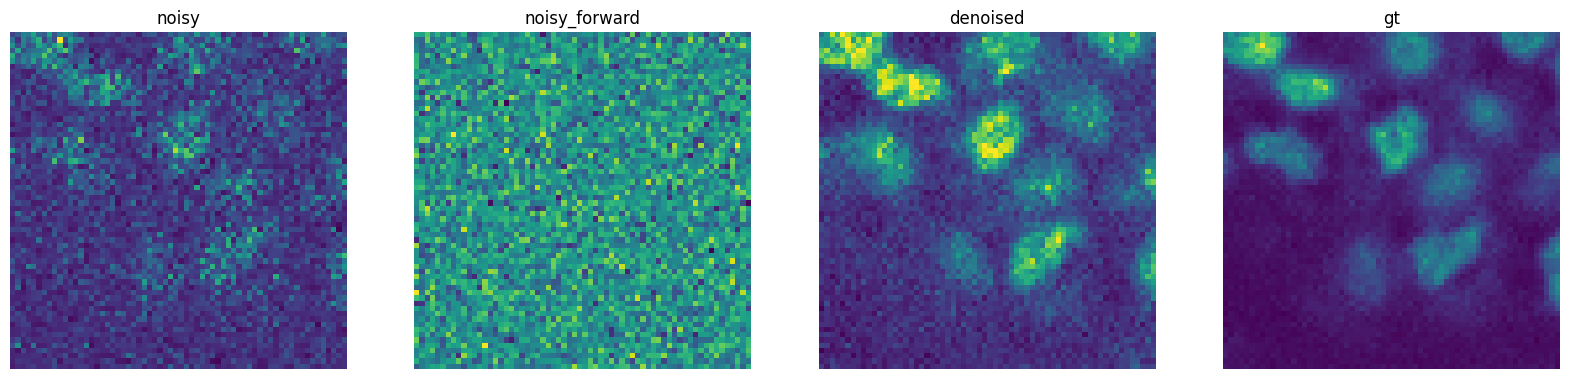

In [169]:
plot_denoise_example(y0, xN_given_y0, img, x0)

In [171]:
metrics_ssim(x0[0, 0].numpy(), 0.5*y0[0, 0].numpy()+0.5)

0.31347506460523306

In [170]:
metrics_ssim(x0[0, 0].numpy(), 0.5*img[0, 0].numpy()+0.5)

0.6110290234396843